# CommonLit - Evaluate Student Summaries Dataset with TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the **CommonLit - Evaluate Student Summaries** dataset made available for this competition.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

# Import the libraries

In [1]:
import string
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
#import os added
import os

2023-09-21 10:45:21.274708: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-21 10:45:21.342105: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 10:45:21.812103: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 10:45:21.815143: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 10:45:23.337999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.13.0
TensorFlow Decision Forests v1.5.0


# Load the Dataset

### Load the prompt csv

**Avant**

In [5]:
#df_train_prompt = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')
#print("Full prompt train dataset shape is {}".format(df_train_prompt.shape))

**Après**

In [3]:
#creating a variable for the path of the data folder
path_data = './commonlit-evaluate-student-summaries/'
#listing the files in the data folder
print(os.listdir(path_data))
df_train_prompt = pd.read_csv(path_data+'prompts_train.csv')

['summaries_test.csv', 'sample_submission.csv:Zone.Identifier', 'summaries_train.csv', 'summaries_train.csv:Zone.Identifier', 'sample_submission.csv', 'prompts_train.csv:Zone.Identifier', 'prompts_test.csv:Zone.Identifier', 'prompts_test.csv', 'prompts_train.csv', 'summaries_test.csv:Zone.Identifier']


In [4]:
print("Full prompt train dataset shape is {}".format(df_train_prompt.shape))

Full prompt train dataset shape is (4, 4)


In [5]:
df_train_prompt.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


The data is composed of 4 columns and 4 entries. We can see all 4 dimensions of our dataset by using the following code:

### Load the summaries csv

In [6]:
#Avant
#df_train_summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')
#print("Full summaries train dataset shape is {}".format(df_train_summaries.shape))

#Après
df_train_summaries = pd.read_csv(path_data+'summaries_train.csv')
print("Full summaries train dataset shape is {}".format(df_train_summaries.shape))

Full summaries train dataset shape is (7165, 5)


The data is composed of 5 columns and 7165 entries. We can see all 5 dimensions of our dataset by printing out the first 5 entries using the following code:

In [7]:
df_train_summaries.head(5)

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


### Combine both summaries and prompt csv's based on prompt id

In [8]:
df_train = df_train_summaries.merge(df_train_prompt, on='prompt_id')
print("Full summaries train dataset shape is {}".format(df_train.shape))

Full summaries train dataset shape is (7165, 8)


The data is composed of 8 columns and 7165 entries. We can see all 8 dimensions of our dataset by printing out the first 5 entries using the following code:

In [9]:
df_train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


# Quick basic dataset exploration

In [10]:
df_train.describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7165 entries, 0 to 7164
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   student_id       7165 non-null   object 
 1   prompt_id        7165 non-null   object 
 2   text             7165 non-null   object 
 3   content          7165 non-null   float64
 4   wording          7165 non-null   float64
 5   prompt_question  7165 non-null   object 
 6   prompt_title     7165 non-null   object 
 7   prompt_text      7165 non-null   object 
dtypes: float64(2), object(6)
memory usage: 503.8+ KB


# Label data distribution

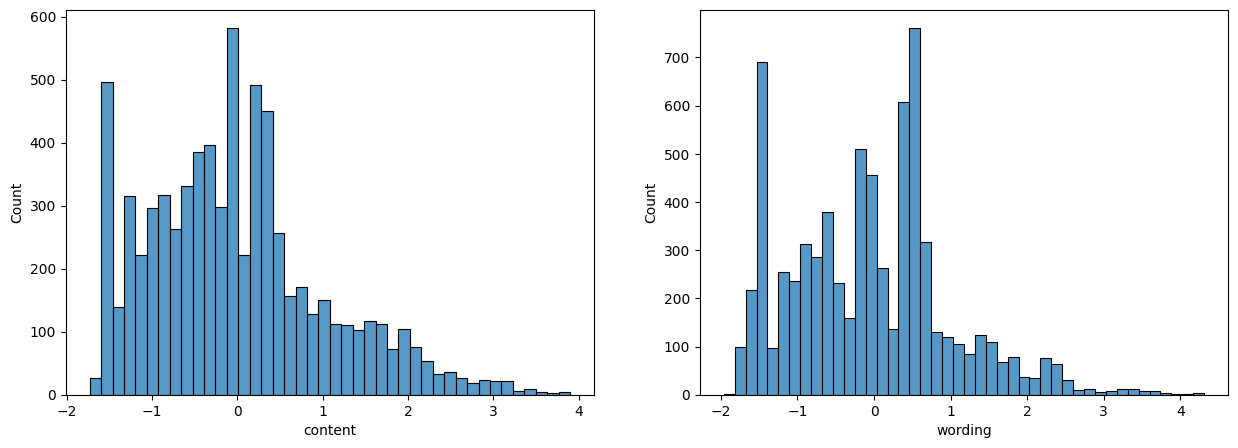

In [12]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df_train, x='content')
plt.subplot(1, 2, 2)
sns.histplot(data=df_train, x='wording')
plt.show()

In [13]:
#check in which measure content and wording are correlated
df_train.corr()

,content,wording
content,1.00000,0.75138
wording,0.75138,1.00000


<AxesSubplot:xlabel='content', ylabel='wording'>

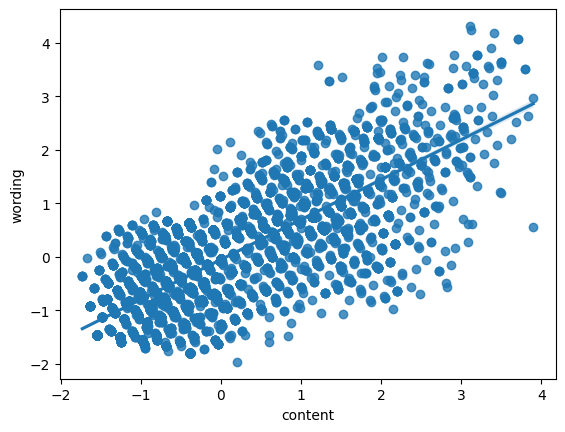

In [14]:
sns.regplot(data=df_train, x='content', y='wording')

# LLM vs Non-LLM solutions

In this notebook, we won't be using an LLM model to embedd the text features. Instead we will calculate some numeric features from the text features like token count, length etc. Using these numeric features, we can create tabular data that can be used train our Model. This approach shows that sometimes non-LLM solutions can also give good results.   

# Preprocess the data

In [15]:
# Reference: https://www.kaggle.com/code/sercanyesiloz/commonlit-tf-idf-xgb-baseline#4.-Feature-Engineering

# A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, 
# both when indexing entries for searching and when retrieving them as the result of a search query.
# Count the stop words in the text.
def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# Count the punctuations in the text.
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

# Count the digits in the text.
def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

# This function applies all the above preprocessing functions on a text feature.
def feature_engineer(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: len(x.split(' ')))
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
    dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    return dataframe

### The distance from the initial text is not taken into account in the current approach. This can be calculated using the Jaccard distance on preprocessed/tokenized text and prompt text 

#### NLP pre-processing step 1 > remove punctuation from text and prompt ####

In [16]:
import string
ls_punct = string.punctuation
#remove punctuation from text using the below function
def remove_ponctuation(text, ls_punct):
    for punct in ls_punct:
        text = text.replace(punct,'')
    return text

In [17]:
df_train['text_cleaned'] = df_train['text'].apply(lambda x: remove_ponctuation(x, ls_punct))
df_train['prompt_text_cleaned'] = df_train['prompt_text'].apply(lambda x: remove_ponctuation(x, ls_punct))
df_train_prompt['prompt_text_cleaned'] = df_train_prompt['prompt_text'].apply(lambda x: remove_ponctuation(x, ls_punct))

#### NLP pre-processing step 2 > remove uppercase

In [18]:
df_train['text_cleaned'] = df_train['text_cleaned'].apply(lambda x: x.lower())
df_train['prompt_text_cleaned'] = df_train['prompt_text_cleaned'].apply(lambda x: x.lower())
df_train_prompt['prompt_text_cleaned'] = df_train_prompt['prompt_text_cleaned'].apply(lambda x: x.lower())

#### NLP pre-processing step 3 > suppress digits

In [19]:
digits = [str(i) for i in list(range(10))]
def remove_numb(text):
    for numb in digits:
        text = text.replace(numb,'')
    return text

In [20]:
df_train['text_cleaned'] = df_train['text_cleaned'].apply(lambda x: remove_numb(x))
df_train['prompt_text_cleaned'] = df_train['prompt_text_cleaned'].apply(lambda x: remove_numb(x))
df_train_prompt['prompt_text_cleaned'] = df_train_prompt['prompt_text_cleaned'].apply(lambda x: remove_numb(x))

#### NLP pre-processing step 4 > suppress stopwords and tokenized the text and prompt_text

In [21]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import word_tokenize
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jerome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jerome/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jerome/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jerome/nltk_data...


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data]   Package omw-1.4 is already up-to-date!


In [22]:
#create a function to remove stopwords from text and prompt_text
#!!!this step also tokenizes the text!!!
stpw = tuple(stopwords.words('english'))

def remove_stopwords(text, stpw):
    output = [i for i in word_tokenize(text) if i not in stpw]
    return output

In [23]:
df_train['text_cleaned'] = df_train['text_cleaned'].apply(lambda x: remove_stopwords(x, stpw))
df_train['prompt_text_cleaned'] = df_train['prompt_text_cleaned'].apply(lambda x: remove_stopwords(x, stpw))
df_train_prompt['prompt_text_cleaned'] = df_train_prompt['prompt_text_cleaned'].apply(lambda x: remove_stopwords(x, stpw))

In [24]:
print(df_train['prompt_text_cleaned'].loc[0])

['background', 'third', 'wave', 'experiment', 'took', 'place', 'cubberley', 'high', 'school', 'palo', 'alto', 'california', 'first', 'week', 'april', 'history', 'teacher', 'ron', 'jones', 'finding', 'unable', 'explain', 'students', 'people', 'throughout', 'history', 'followed', 'crowd', 'even', 'terrible', 'things', 'happening', 'decided', 'demonstrate', 'students', 'experiment', 'jones', 'announced', 'starting', 'movement', 'aimed', 'eliminate', 'democracy', 'jones', 'named', 'movement', '“', 'third', 'wave', '”', 'symbol', 'strength', 'referring', 'mythical', 'belief', 'third', 'series', 'waves', 'strongest', 'one', 'central', 'points', 'movement', 'democracy', '’', 'main', 'weakness', 'favors', 'individual', 'whole', 'community', 'jones', 'emphasized', 'main', 'point', 'movement', 'created', 'catchy', 'motto', '“', 'strength', 'discipline', 'strength', 'community', 'strength', 'action', 'strength', 'pride', '”', 'experiment', 'jones', 'started', 'first', 'day', 'experiment', 'emphas

#### NLP pre-processing step 4 > Lemmatize text and prompt_text

In [25]:
from nltk.stem import WordNetLemmatizer

In [45]:
#create a function to lemmatize the text and remove words with length less than 2
#return the text as a string
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    output = []
    for word in text:
        if len(word) > 2:
            output.append(lemmatizer.lemmatize(word))
    return ' '.join(output)

In [27]:
df_train['text_cleaned'] = df_train['text_cleaned'].apply(lambda x: lemmatize_text(x))
df_train['prompt_text_cleaned'] = df_train['prompt_text_cleaned'].apply(lambda x: lemmatize_text(x))
df_train_prompt['prompt_text_cleaned'] = df_train_prompt['prompt_text_cleaned'].apply(lambda x: lemmatize_text(x))

In [28]:
print(df_train['text_cleaned'].loc[0])

third wave experimentto see people reacted new one leader government gained popularity people wanted try new thing student follow anything said start turning eachother gain higher power stop experement many people got radical blindly following leader


In [29]:
#create a function to make a list out of the text and the prompt_text
def make_list(text):
    return text.split(' ')

#apply the function to the text and prompt_text
df_train_prompt['prompt_text_cleaned_list'] = df_train_prompt['prompt_text_cleaned'].apply(lambda x: make_list(x))

In [30]:
df_train_prompt

,prompt_id,prompt_question,prompt_title,prompt_text,prompt_text_cleaned,prompt_text_cleaned_list
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,chapter sequel already said must proceed consi...,"[chapter, sequel, already, said, must, proceed..."
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,egyptian society structured like pyramid top g...,"[egyptian, society, structured, like, pyramid,..."
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,background third wave experiment took place cu...,"[background, third, wave, experiment, took, pl..."
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",one member trimming beef cannery another worki...,"[one, member, trimming, beef, cannery, another..."


#### NLP pre-processing step 4 > Transform texts in count vectorized matrix. 
##### Since the goal is to calculate a jaccard similarity between text and prompt_text, the count_vectorization is dependant upon the prompt_id. 
##### Also the Jaccard similarity might be considered regarding the kind of word analyzed (i.e. verb, adjective, noun) > which can be recovered using the nltk.pos_tag

In [58]:
#first let's create list of words from specific part of speech from the prompt_text
#we will use the nltk library to tag the words and the average perceptron tagger
nltk.download('averaged_perceptron_tagger')

#the post tagger tags the words with their part of speech
def create_tags_list(text, tags):
    output = [] 
    for word in text:
        if nltk.pos_tag([word])[0][1] in tags:
            output.append(word)
    return output

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jerome/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [59]:
#we should try to find the most common verb (i.e the most common word with tag VB an VBZ and VBP and VBD and VBN and VBG), 
#noun (i.e the most common word with tag NN and NNS and NNP and NNPS)
#and adjective (i.e the most common word with tag JJ and JJR and JJS)
dict_tags = {'verb': ['VB', 'VBZ', 'VBP', 'VBD', 'VBN', 'VBG'],
             'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
             'adj': ['JJ', 'JJR', 'JJS']}
 
for item in dict_tags.keys():
    df_train_prompt[f'{item}_list'] = df_train_prompt['prompt_text_cleaned_list'].apply(lambda x: create_tags_list(x, dict_tags[item]))

In [53]:
for i in dict_tags.keys():
    print(dict_tags[i])

['VB', 'VBZ', 'VBP', 'VBD', 'VBN', 'VBG']
['NN', 'NNS', 'NNP', 'NNPS']
['JJ', 'JJR', 'JJS']


In [60]:
df_train_prompt

,prompt_id,prompt_question,prompt_title,prompt_text,prompt_text_cleaned,prompt_text_cleaned_list,VB_list,NN_list,JJ_list,verb_list,noun_list,adj_list
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,chapter sequel already said must proceed consi...,"[chapter, sequel, already, said, must, proceed...",[],[chapter],[],"[said, consider, constructing, produced, seen,...","[chapter, sequel, proceed, poet, aim, avoid, p...","[specific, complex, virtuous, bad, single, mor..."
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,egyptian society structured like pyramid top g...,"[egyptian, society, structured, like, pyramid,...",[],[],[egyptian],"[structured, believed, controlled, keep, make,...","[society, pyramid, top, god, osiris, isi, god,...","[egyptian, egyptian, important, happy, egyptia..."
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,background third wave experiment took place cu...,"[background, third, wave, experiment, took, pl...",[],[background],[],"[took, finding, followed, happening, decided, ...","[background, wave, experiment, place, cubberle...","[third, high, unable, terrible, third, mythica..."
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",one member trimming beef cannery another worki...,"[one, member, trimming, beef, cannery, another...",[],[],[],"[trimming, working, spoiled, used, worked, tak...","[member, beef, cannery, sausage, factory, fami...","[great, whole, new, old, fresh, whole, ingenio..."


In [148]:
#import the TfidfVectorizer
#this will be used to convert text to numbers
from sklearn.feature_extraction.text import CountVectorizer

In [149]:
#let check whether the student_id is unique
print(f'the dimmension of df_train are {df_train.shape}')
print(f"the number of unique student_id is {len(df_train['student_id'].unique().tolist())}")
#ok the number of row in df_train is equal to the number of unique student_id, then we can use student_id as key for further merge

the dimmension of df_train are (7165, 15)
the number of unique student_id is 7165


In [ ]:
#from prompt_id dataframe we create a columns with the list of word in prompt_text_cleaned
prompt_

In [257]:
#we need to create a dictionnaries were trained and transformed Countvectorizers will be stored for each prompt_id
#this will be used to transform the test dataset respectively to each prompt_id
prompt_id = df_train_prompt['prompt_id'].unique().tolist()

CountVectorizer_fitted_dict = {}
CountVectorizer_transformed_dict = {}
for item in prompt_id:
    vectorizer = CountVectorizer(max_features=50)
    X = vectorizer.fit(df_train_prompt.prompt_text_cleaned.loc[df_train_prompt.prompt_id == item])
    CountVectorizer_fitted_dict[item] = X
    CountVectorizer_transformed_dict[item] = X.transform(df_train_prompt.prompt_text_cleaned.loc[df_train_prompt.prompt_id == item])

In [41]:
df_train.columns

Index(['student_id', 'prompt_id', 'text', 'content', 'wording',
       'prompt_question', 'prompt_title', 'prompt_text', 'text_cleaned',
       'prompt_text_cleaned', 'text_cleaned_list', 'prompt_text_cleaned_list'],
      dtype='object')

In [258]:
#we create a function to transform the text to numbers using the trained CountVectorizers
#we use the prompt_id to select the right CountVectorizer
#we return the transformed text as a numpy array
#we also return the CountVectorizer used to transform the text
#we transform the text to a numpy array and changed it to binary data to be able to use it in the Jaccard similarity function
#then we return the Jaccard similarity between the text and the prompt_text
from sklearn.metrics import jaccard_score

def calculate_Jaccard_dist(text, prompt_id, CountVectorizer_fitted_dict, CountVectorizer_transformed_dict):
    vectorizer = CountVectorizer_fitted_dict[prompt_id]
    text_transformed = vectorizer.transform([text]).toarray()
    prompt_text_transformed = CountVectorizer_transformed_dict[prompt_id].toarray()
    txt = np.array([i if i == 0 else 1 for i in text_transformed.tolist()[0]])
    prompt = np.array([i if i == 0 else 1 for i in prompt_text_transformed.tolist()[0]])  
    return jaccard_score(txt, prompt)

In [259]:
#we apply the function to the train dataset
df_train['Jaccard_dist'] = df_train.apply(lambda x: calculate_Jaccard_dist(x['text_cleaned'], x['prompt_id'], CountVectorizer_fitted_dict, CountVectorizer_transformed_dict), axis=1)

In [2]:
#we check the distribution of the Jaccard_dist
sns.histplot(data=df_train, x='log_Jaccard_dist', kde=True)

NameError: name 'sns' is not defined

In [261]:
prompt_id

['39c16e', '3b9047', '814d6b', 'ebad26']

In [262]:
#create a columns with the log of Jaccard_dist + 1
#we add 1 to avoid having -inf when the Jaccard_dist is 0
df_train['log_Jaccard_dist'] = np.log(df_train['Jaccard_dist'] + 1)

<AxesSubplot:xlabel='log_Jaccard_dist', ylabel='wording'>

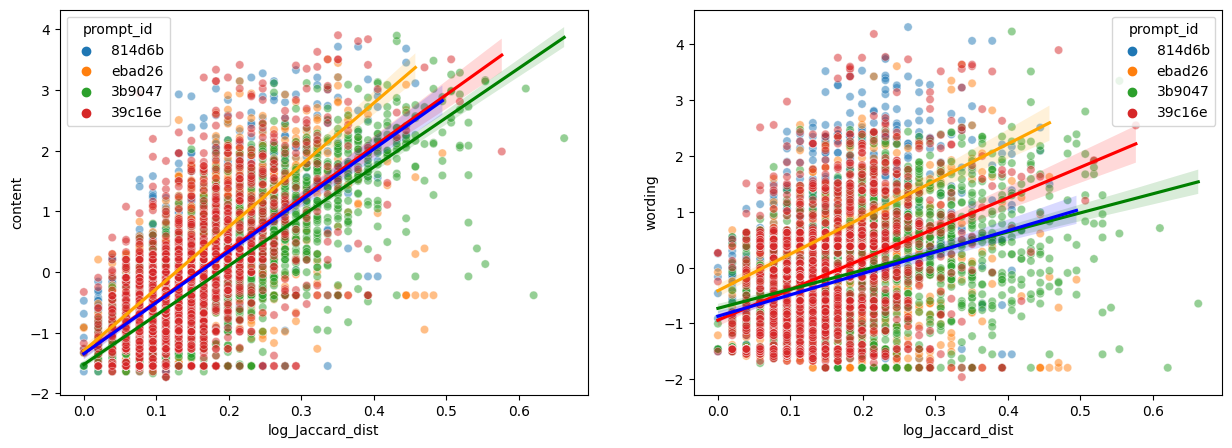

In [263]:
#we check for correlation between the Jaccard_dist and the target
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_train, x='log_Jaccard_dist', y='content', hue='prompt_id', alpha=0.5)
sns.regplot(data=df_train.loc[df_train['prompt_id'] == prompt_id[0]], x='log_Jaccard_dist', y='content', scatter=False, color='red')
sns.regplot(data=df_train.loc[df_train['prompt_id'] == prompt_id[1]], x='log_Jaccard_dist', y='content', scatter=False, color='green')
sns.regplot(data=df_train.loc[df_train['prompt_id'] == prompt_id[2]], x='log_Jaccard_dist', y='content', scatter=False, color='orange')
sns.regplot(data=df_train.loc[df_train['prompt_id'] == prompt_id[3]], x='log_Jaccard_dist', y='content', scatter=False, color='blue')
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_train, x='log_Jaccard_dist', y='wording', hue='prompt_id', alpha=0.5)
sns.regplot(data=df_train.loc[df_train['prompt_id'] == prompt_id[0]], x='log_Jaccard_dist', y='wording', scatter=False, color='red')
sns.regplot(data=df_train.loc[df_train['prompt_id'] == prompt_id[1]], x='log_Jaccard_dist', y='wording', scatter=False, color='green')
sns.regplot(data=df_train.loc[df_train['prompt_id'] == prompt_id[2]], x='log_Jaccard_dist', y='wording', scatter=False, color='orange')
sns.regplot(data=df_train.loc[df_train['prompt_id'] == prompt_id[3]], x='log_Jaccard_dist', y='wording', scatter=False, color='blue')

In [264]:
#let's check the correlation between the Jaccard_dist and the targets
from sklearn.metrics import r2_score
r2_content = r2_score(df_train['content'], df_train['log_Jaccard_dist'])
r2_wording = r2_score(df_train['wording'], df_train['log_Jaccard_dist'])
print(f'the r2 score between the Jaccard_dist and the content is {r2_content} while the r2 score between the Jaccard_dist and the wording is {r2_wording}')

the r2 score between the Jaccard_dist and the content is 0.08017503216829813 while the r2 score between the Jaccard_dist and the wording is 0.004185943355777932



from sklearn.metrics import r2_score

In [219]:
df_train.columns

Index(['student_id', 'prompt_id', 'text', 'content', 'wording',
       'prompt_question', 'prompt_title', 'prompt_text', 'text_word_cnt',
       'text_length', 'text_stopword_cnt', 'text_punct_cnt', 'text_number_cnt',
       'text_cleaned', 'prompt_text_cleaned', 'Jaccard_dist'],
      dtype='object')

In [214]:
df_train.columns

Index(['student_id', 'prompt_id', 'text', 'content', 'wording',
       'prompt_question', 'prompt_title', 'prompt_text', 'text_word_cnt',
       'text_length', 'text_stopword_cnt', 'text_punct_cnt', 'text_number_cnt',
       'text_cleaned', 'prompt_text_cleaned', 'Jaccard_dist'],
      dtype='object')

In [192]:
df_train.iloc[0]

student_id                                                  000e8c3c7ddb
prompt_id                                                         814d6b
text                   The third wave was an experimentto see how peo...
content                                                         0.205683
wording                                                         0.380538
prompt_question        Summarize how the Third Wave developed over su...
prompt_title                                              The Third Wave
prompt_text            Background \r\nThe Third Wave experiment took ...
text_word_cnt                                                         61
text_length                                                          346
text_stopword_cnt                                                     25
text_punct_cnt                                                         3
text_number_cnt                                                        0
text_cleaned           third wave experimentto see 

In [68]:
df_train

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt,text_cleaned,prompt_text_cleaned
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,61,346,25,3,0,the third wave was an experimentto see how peo...,background \r\nthe third wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,206,1225,92,30,3,the third wave developed rapidly because the ...,background \r\nthe third wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,60,345,27,9,0,the third wave only started as an experiment w...,background \r\nthe third wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,76,451,35,10,0,the experimen was orginally about how even whe...,background \r\nthe third wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,27,145,12,2,0,the third wave developed so quickly due to the...,background \r\nthe third wave experiment took ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160,fef3e85236e5,39c16e,"It has to be made on a complex storyline, with...",-0.981265,-1.548900,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,33,180,16,1,0,it has to be made on a complex storyline with ...,chapter \r\nas the sequel to what has already...
7161,ff0f65eecf02,39c16e,Aristotle descirbes an ideal tradgedy as being...,-0.511077,-1.589115,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,30,163,15,3,0,aristotle descirbes an ideal tradgedy as being...,chapter \r\nas the sequel to what has already...
7162,ff186473ea0a,39c16e,A tragedy should have a complex plan not a sim...,-0.834946,-0.593749,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,29,150,16,3,0,a tragedy should have a complex plan not a sim...,chapter \r\nas the sequel to what has already...
7163,ff5e9e6068da,39c16e,Aristotle believed that the ideal tradegy shou...,-0.157460,-0.165811,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,50,297,22,4,0,aristotle believed that the ideal tradegy shou...,chapter \r\nas the sequel to what has already...


In [13]:
preprocessed_df = feature_engineer(df_train)
print("Full summaries train dataset shape is {}".format(preprocessed_df.shape))

Full summaries train dataset shape is (7165, 13)


In [51]:
preprocessed_df.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,61,346,25,3,0
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,206,1225,92,30,3
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,60,345,27,9,0
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,76,451,35,10,0
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,27,145,12,2,0


The data is composed of 13 columns and 7165 entries. We can see all 13 dimensions of our dataset by printing out the first 5 entries using the following code:

In [17]:
preprocessed_df.describe()

,content,wording,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,76.155618,418.776971,36.306769,9.355059,0.378786
std,1.043569,1.036048,54.538587,307.833685,25.813092,9.474397,0.937313
min,-1.729859,-1.962614,22.000000,114.000000,5.000000,0.000000,0.000000
25%,-0.799545,-0.872720,40.000000,216.000000,19.000000,4.000000,0.000000
50%,-0.093814,-0.081769,59.000000,320.000000,28.000000,6.000000,0.000000
75%,0.499660,0.503833,93.000000,513.000000,45.000000,12.000000,0.000000
max,3.900326,4.310693,651.000000,3940.000000,315.000000,162.000000,14.000000


## Extract feature columns

In [19]:
FEATURE_COLUMNS = preprocessed_df.drop(columns = ['student_id', 'prompt_id', 'text', 'prompt_question', 
                                           'prompt_title', 'prompt_text', 'content', 'wording'], axis = 1).columns.to_list()

In [20]:
FEATURE_COLUMNS

['text_word_cnt',
 'text_length',
 'text_stopword_cnt',
 'text_punct_cnt',
 'text_number_cnt']

## Plot feature columns

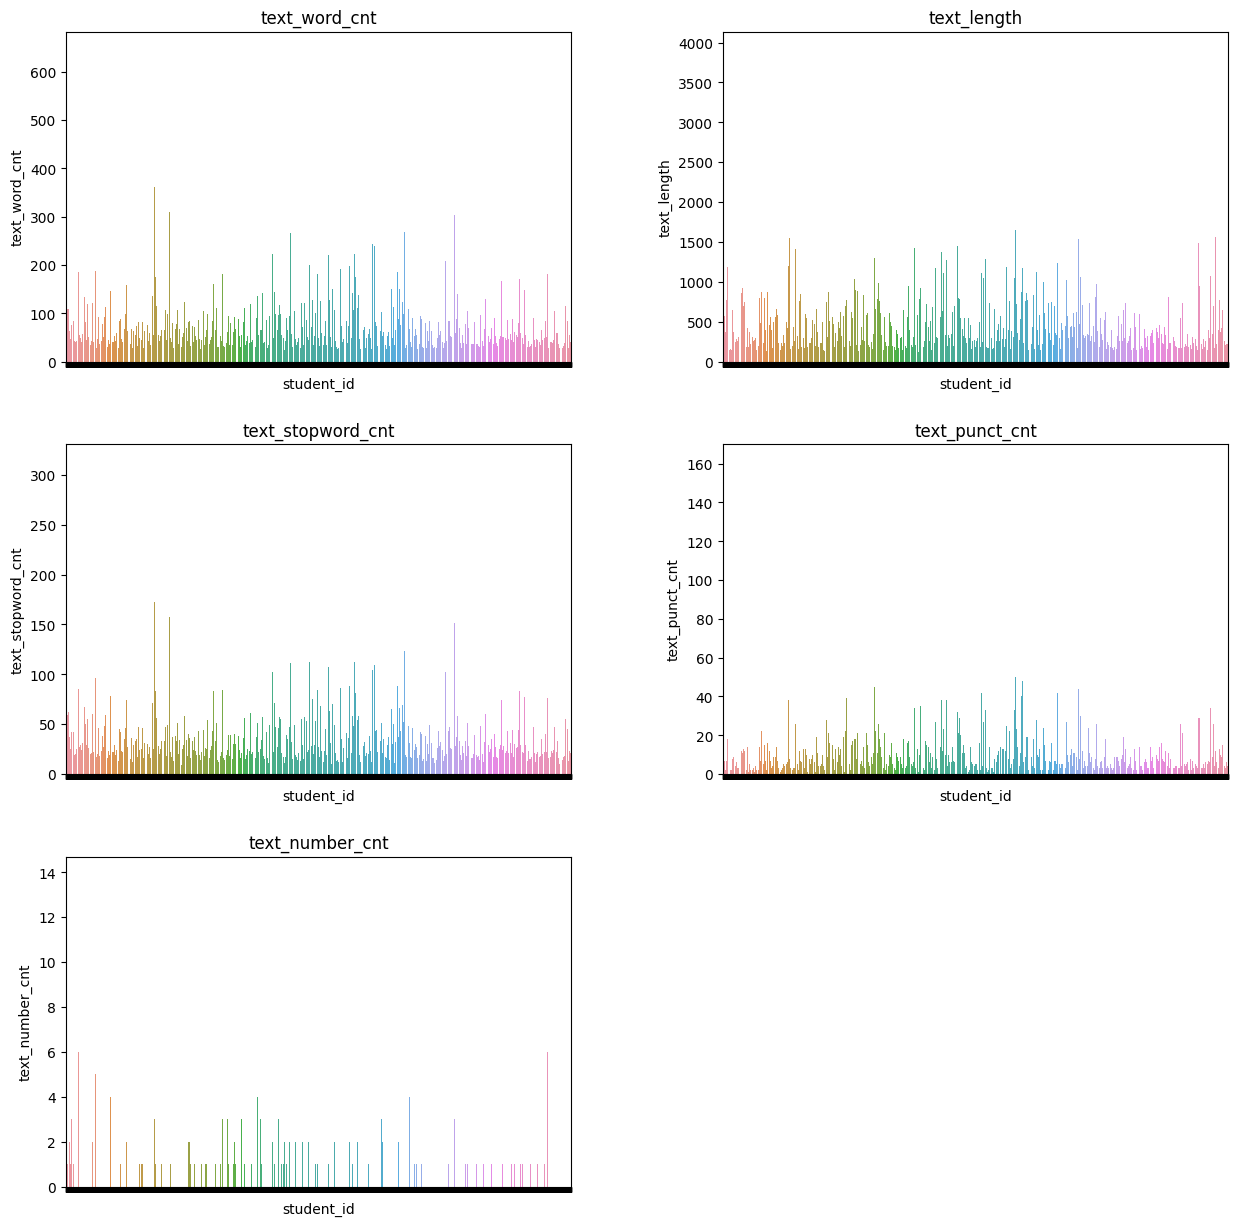

In [21]:
#plot feature does not give a lot of information there... see below
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(FEATURE_COLUMNS):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=preprocessed_df['student_id'], y=preprocessed_df[column_name])
    bp.set(xticklabels=[])
    axis[row, col].set_title(column_name)
axis[2, 1].set_visible(False)
plt.show()

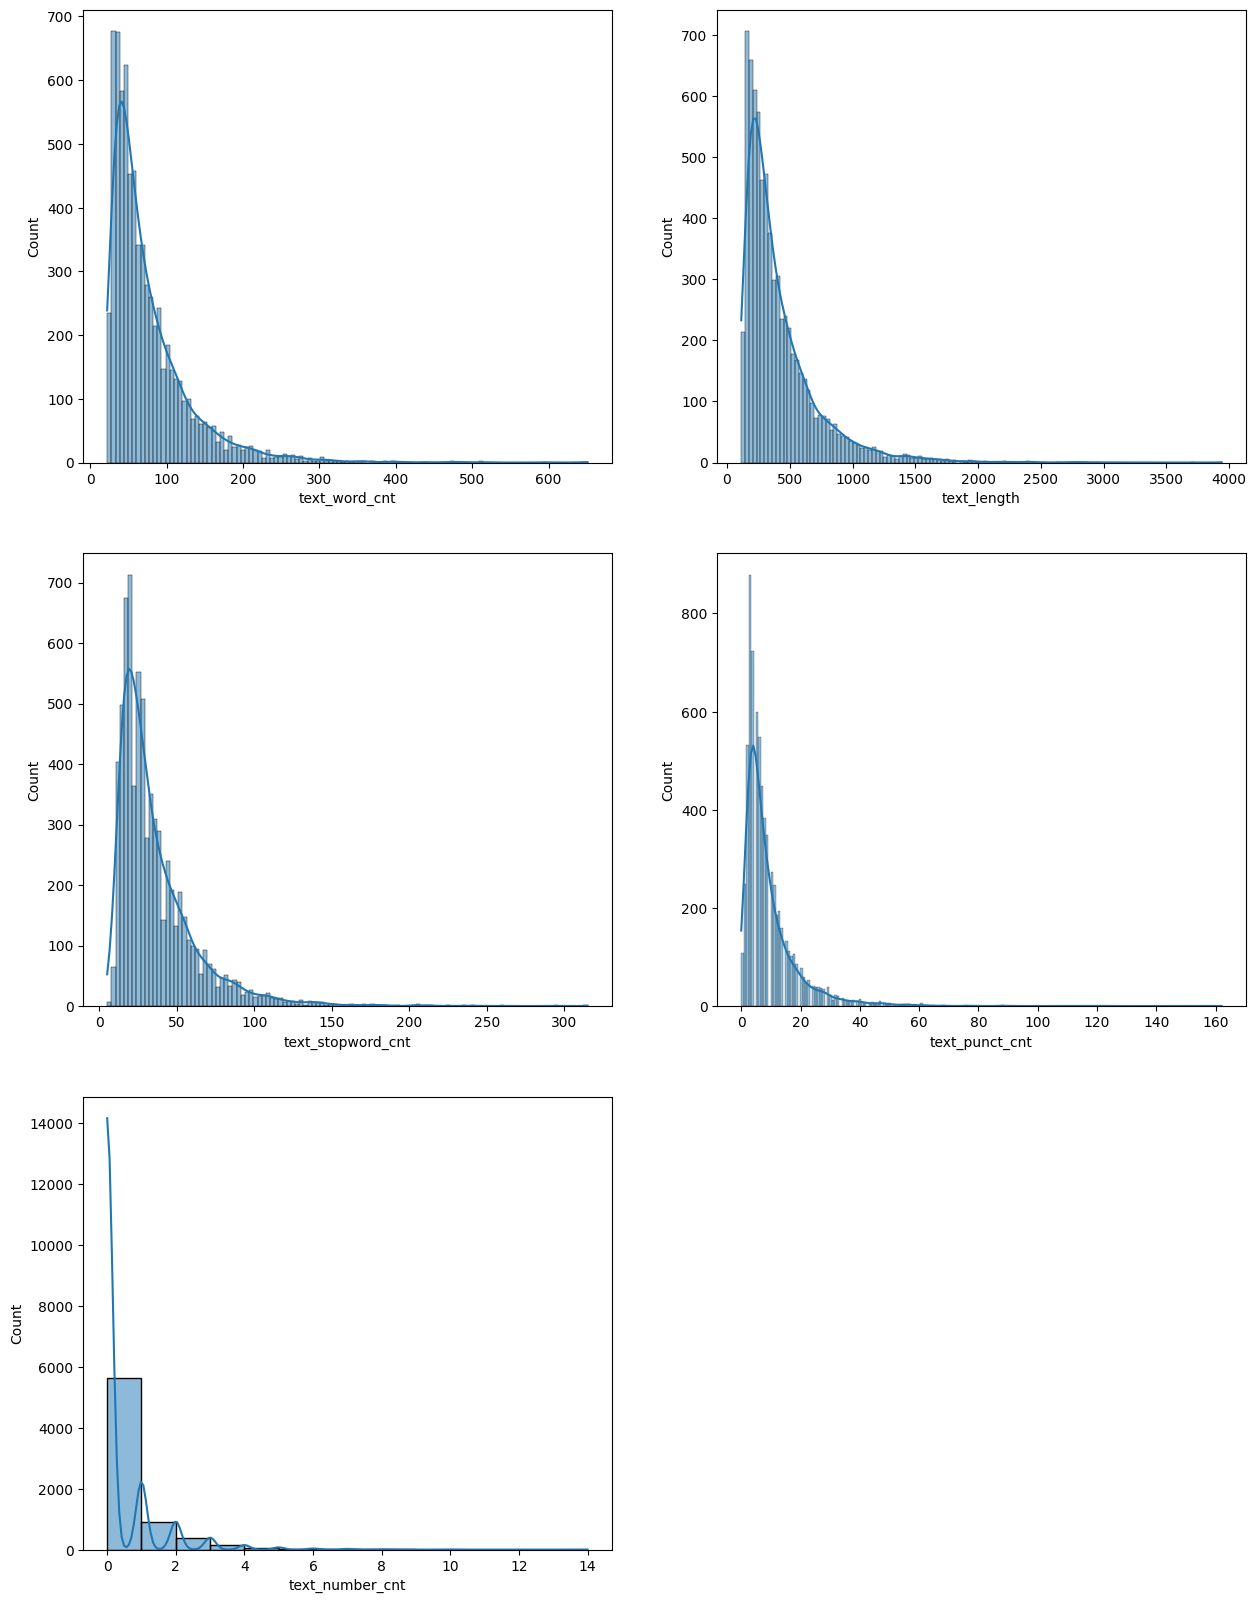

In [31]:
#checking the distribution is more informative
#make a list of the df_train columns from 8 to the end to get the name of features engineered
col = df_train.columns[8:]

#the plot is generated using a loop on the list of features engineered 
plt.figure(figsize = (15, 20))
for i, item in enumerate(col):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=df_train, x=item, kde=True)
plt.show()

### The distribution of features are right-skewed therefore the use of a non-parametric model such as decision tree regression is preferred 

Now let us split the dataset into training and testing datasets:

In [25]:
'''def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(preprocessed_df)
train_ds_pd.shape, valid_ds_pd.shape'''

#sklearn library train_test_split function can be used instead of the above function
#in addition, the random_state parameter can be used to ensure that the same split is made each time
#as well as the stratify parameter to ensure that the distribution of the target variable is the same in the train and validation sets
#as weel as the schuffle parameter to ensure that the data is shuffled before splitting
from sklearn.model_selection import train_test_split
train_ds_pd, valid_ds_pd = train_test_split(preprocessed_df, test_size=0.2, random_state=42, shuffle=True)
train_ds_pd.shape, valid_ds_pd.shape

((5732, 13), (1433, 13))

In [23]:
train_ds_pd.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,60,345,27,9,0
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,76,451,35,10,0
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,27,145,12,2,0
5,014e2395b3c4,814d6b,The Thrid Wave movement in the school has more...,1.376083,2.389443,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,126,734,67,7,0
6,01d303ea2f62,814d6b,The Third Wave developed and spead over such a...,0.735204,2.346576,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,133,767,68,16,0


There's one more step required before we can train the model. We need to convert the datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

By default the Random Forest Model is configured to train classification tasks. Since this is a regression problem, we will specify the type of the task (`tfdf.keras.Task.REGRESSION`) as a parameter here.

In [32]:
# `content` label datatset columns
FEATURE_CONTENT = FEATURE_COLUMNS + ['content']

# `wording` label datatset columns
FEATURE_WORDING = FEATURE_COLUMNS + ['wording']

# Convert dataframes to corresponding datasets
content_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd[FEATURE_CONTENT], label='content', task = tfdf.keras.Task.REGRESSION)
wording_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd[FEATURE_WORDING], label='wording', task = tfdf.keras.Task.REGRESSION)

# Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [33]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

# Configure the model

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

# Create a Random Forest

Today, we will use the defaults to create the Random Forest Model while specifiyng the task type as `tfdf.keras.Task.REGRESSION`.

In [34]:
# Create RandomForestModel for label content
model_content = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_content.compile(metrics=["mse"])

# Create RandomForestModel for label wording
model_wording = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_wording.compile(metrics=["mse"])

Use /tmp/tmpo20ewpbz as temporary training directory
Use /tmp/tmppqntojg1 as temporary training directory


# Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

In [38]:
# Training RandomForestModel for label content
model_content.fit(x=content_train_ds)

Reading training dataset...
Training dataset read in 0:00:00.015152. Found 5732 examples.
Training model...


[INFO 23-09-19 14:39:36.8085 CEST kernel.cc:1243] Loading model from path /tmp/tmpo20ewpbz/model/ with prefix 769d249463ad4cb9


Model trained in 0:00:00.929404
Compiling model...
Model compiled.


[INFO 23-09-19 14:39:37.1404 CEST decision_forest.cc:660] Model loaded with 300 root(s), 460804 node(s), and 5 input feature(s).
[INFO 23-09-19 14:39:37.1404 CEST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-19 14:39:37.1404 CEST kernel.cc:1075] Use fast generic engine


In [40]:
# Training RandomForestModel for label wording
model_wording.fit(x=wording_train_ds)

Reading training dataset...
Training dataset read in 0:00:00.014766. Found 5732 examples.
Training model...


[INFO 23-09-19 14:40:02.4698 CEST kernel.cc:1243] Loading model from path /tmp/tmppqntojg1/model/ with prefix ccac61afa65f4440


Model trained in 0:00:00.930416
Compiling model...
Model compiled.


[INFO 23-09-19 14:40:02.8581 CEST decision_forest.cc:660] Model loaded with 300 root(s), 448386 node(s), and 5 input feature(s).
[INFO 23-09-19 14:40:02.8582 CEST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-19 14:40:02.8582 CEST kernel.cc:1075] Use fast generic engine


# Visualize the model
One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300. We can select a tree to display below.

In [39]:
# Visualize model_content
tfdf.model_plotter.plot_model_in_colab(model_content, tree_idx=0, max_depth=3)

In [41]:
# Visualize model_content
tfdf.model_plotter.plot_model_in_colab(model_wording, tree_idx=0, max_depth=3)

# Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training the dataset we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the Root Mean Squared Error (RMSE) evaluated on the out-of-bag dataset according to the number of trees in the model. Let us plot this.

Note: Smaller values are better for this hyperparameter.

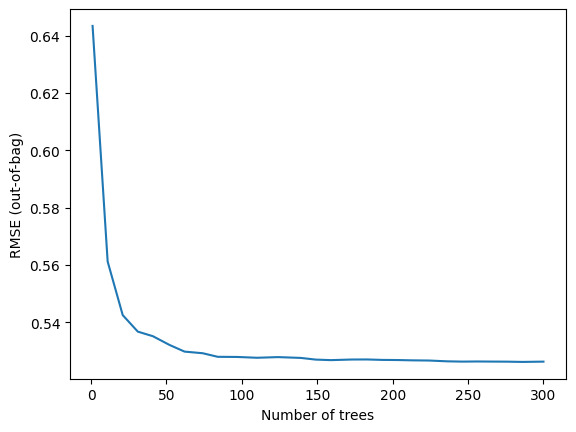

In [42]:
# Plot log data for model_content
logs = model_content.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

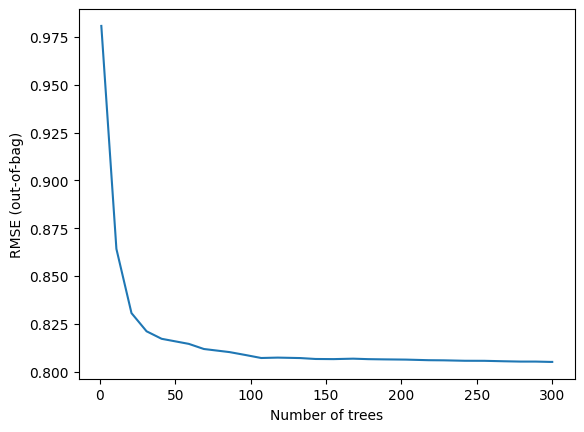

In [43]:
# Plot log data for model_wording
logs = model_wording.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

We can also see some general stats on the OOB dataset:

In [44]:
# General stats for model_content
inspector_content = model_content.make_inspector()
inspector_content.evaluation()

Evaluation(num_examples=5732, accuracy=None, loss=None, rmse=0.5262385700568615, ndcg=None, aucs=None, auuc=None, qini=None)

In [45]:
# General stats for model_wording
inspector_wording = model_wording.make_inspector()
inspector_wording.evaluation()

Evaluation(num_examples=5732, accuracy=None, loss=None, rmse=0.8050801756379421, ndcg=None, aucs=None, auuc=None, qini=None)

Now, let us run an evaluation using the validation dataset.

In [46]:
# Create validation dataset for model_content
valid_ds_content = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd[FEATURE_CONTENT], label="content", task = tfdf.keras.Task.REGRESSION)

# Create validation dataset for model_wording
valid_ds_wording = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd[FEATURE_WORDING], label="wording", task = tfdf.keras.Task.REGRESSION)

# Run evaluation for model_content
evaluation_content = model_content.evaluate(x=valid_ds_content,return_dict=True)
for name, value in evaluation_content.items():
  print(f"{name}: {value:.4f}")

# Run evaluation for model_wording
evaluation_wording = model_wording.evaluate(x=valid_ds_wording,return_dict=True)
for name, value in evaluation_wording.items():
  print(f"{name}: {value:.4f}")

2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - mse: 0.2715
loss: 0.0000
mse: 0.2715
2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - mse: 0.5991
loss: 0.0000
mse: 0.5991


# Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [47]:
print(f"Available variable importances for model_content:")
for importance in inspector_content.variable_importances().keys():
  print("\t", importance)

Available variable importances for model_content:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES


In [48]:
print(f"Available variable importances for model_wording:")
for importance in inspector_wording.variable_importances().keys():
  print("\t", importance)

Available variable importances for model_wording:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [49]:
# For model_content.
# Each line is: (feature name, (index of the feature), importance score)
inspector_content.variable_importances()["NUM_AS_ROOT"]

[("text_length" (1; #1), 188.0),
 ("text_word_cnt" (1; #5), 84.0),
 ("text_stopword_cnt" (1; #4), 28.0)]

In [50]:
# For model_wording.
# Each line is: (feature name, (index of the feature), importance score)
inspector_wording.variable_importances()["NUM_AS_ROOT"]

[("text_length" (1; #1), 188.0),
 ("text_word_cnt" (1; #5), 70.0),
 ("text_stopword_cnt" (1; #4), 42.0)]

# Submission

In [ ]:
df_test_prompt = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv')
df_test_summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv')

In [ ]:
df_test = df_test_summaries.merge(df_test_prompt, on='prompt_id')

In [ ]:
df_test.head()

In [ ]:
processed_test_df = feature_engineer(df_test)

In [ ]:
processed_test_df.head()

In [ ]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(processed_test_df[FEATURE_COLUMNS], task = tfdf.keras.Task.REGRESSION)

In [ ]:
processed_test_df['content'] = model_content.predict(test_ds)
processed_test_df['wording'] = model_wording.predict(test_ds)

In [ ]:
processed_test_df.head()

In [ ]:
processed_test_df[['student_id', 'content', 'wording']].to_csv('submission.csv',index=False)
display(pd.read_csv('submission.csv'))